---

# Reinforcement Learning Programming - CSCN8020
# Assignment 3

---

## Install Dependencies and Import Libraries

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

In [3]:
!pip install gym[atari] torch torchvision numpy matplotlib
!pip install gym torch numpy matplotlib
!pip install gym[accept-rom-license]
!pip install numpy==1.23.5




INFO: pip is looking at multiple versions of gym[atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 14.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446710 sha256=d457ff31caf5e971d411158253bddfda40d64638f4bc867d17aafd2edd5f36aa
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 104.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.2.0 requires numpy>=1.26, b

---

## Define the Deep Q-Network (DQN) Model

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
class QNetwork(nn.Module):
    def __init__(self, input_shape, action_count):
        super(QNetwork, self).__init__()
        # Convolutional layers section
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # Convolutional layer 1: input channels=4, output channels=32, kernel size=8x8, stride=4
            nn.ReLU(),                                    # ReLU activation function
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # Convolutional layer 2: input channels=32, output channels=64, kernel size=4x4, stride=2
            nn.ReLU(),                                    # ReLU activation function
            nn.Conv2d(64, 64, kernel_size=3, stride=1), # Convolutional layer 3: input channels=64, output channels=64, kernel size=3x3, stride=1
            nn.ReLU()                                     # ReLU activation function
        )

        # Fully connected layers section
        self.dense_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),  # Fully connected layer 1: input features = 64*7*7 (flattened conv output), output features = 512
            nn.ReLU(),                    # ReLU activation function
            nn.Linear(512, action_count)   # Fully connected layer 2: input features = 512, output features = action_count (number of possible actions)
        )

    def forward(self, state):
        # Pass state through convolutional layers
        features = self.conv_layers(state)
        # Flatten the feature map
        flattened = features.view(features.size(0), -1) # Reshape the feature map to be flat for the dense layers
        # Pass flattened features through fully connected layers and return Q-values
        q_values = self.dense_layers(flattened)
        return q_values

---

## Create Preprocessing Function

In [2]:
import cv2
import numpy as np  # Assuming numpy is used for np.expand_dims and astype

def preprocess(obs):
    """
    Preprocesses a raw observation (frame) from the environment for DQN input.

    Args:
        obs (numpy.ndarray): Raw observation frame (typically RGB image).

    Returns:
        numpy.ndarray: Preprocessed observation frame (grayscale, resized, normalized, and expanded dims).
    """
    obs = obs[34:194, :, :]  # Crop the observation to focus on the game area (remove top and bottom parts)
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)  # Convert the RGB observation to grayscale to reduce dimensionality
    obs = cv2.resize(obs, (84, 84))  # Resize the grayscale observation to 84x84 pixels for smaller input size
    obs = np.expand_dims(obs, axis=0) / 255.0  # Normalize pixel values to the range [0, 1] by dividing by 255.0 and expand dimensions to create a channel dimension (for CNN input)
    return obs.astype(np.float32) # Change the data type to float32 for neural network compatibility

---

## Define Replay Memory

In [3]:
class ExperienceReplayBuffer:  # Changed class name to be more descriptive (ExperienceReplayBuffer)
    """
    Experience Replay Buffer for DQN agent.

    Stores and samples experiences for training the DQN.
    """
    def __init__(self, capacity):
        """
        Initializes the ExperienceReplayBuffer.

        Args:
            capacity (int): Maximum capacity of the replay buffer (maximum number of experiences to store).
        """
        self.buffer = deque(maxlen=capacity)  # Use deque for efficient FIFO buffer

    def add_experience(self, state, action, reward, next_state, done): # Changed method name from push to add_experience
        """
        Adds a new experience tuple to the replay buffer.

        Args:
            state (object): Current state.
            action (int): Action taken in the current state.
            reward (float): Reward received after taking the action.
            next_state (object): Next state after taking the action.
            done (bool): Boolean indicating if the episode terminated after this step.
        """
        self.buffer.append((state, action, reward, next_state, done)) # Append the experience tuple to the buffer

    def sample_batch(self, batch_size): # Changed method name from sample to sample_batch
        """
        Samples a random batch of experiences from the replay buffer.

        Args:
            batch_size (int): Number of experiences to sample.

        Returns:
            list: A list of experience tuples (state, action, reward, next_state, done), randomly sampled from the buffer.
        """
        if len(self.buffer) < batch_size: # Check if buffer has enough experiences to sample
            return None # Or raise an exception, or return fewer samples - handle as needed in training loop

        return random.sample(self.buffer, batch_size) # Randomly sample a batch of experiences

    def __len__(self):
        """
        Returns the current number of experiences in the replay buffer.

        Returns:
            int: Current size of the replay buffer.
        """
        return len(self.buffer) # Return the length of the deque buffer

---

## Set up Training Parameters

In [4]:
import gym
env = gym.make("PongDeterministic-v4")
num_actions = env.action_space.n
input_shape = (4, 84, 84)  # 4 stacked frames

##### _This code initializes the Pong game environment using OpenAI Gym. It specifies the number of possible actions and sets the input shape to four stacked frames of size 84x84 to enhance decision-making._

## Set default hyperparameters & Initialize networks as assignment request

In [5]:
batch_size = 8
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
target_update_rate = 10
memory_capacity = 10000
lr = 1e-4

# Initialize networks
policy_net = QNetwork(input_shape, num_actions)
target_net = QNetwork(input_shape, num_actions)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
replay_buffer = ExperienceReplayBuffer(memory_capacity)

##### _This code configures key hyperparameters for training a Deep Q-Network (DQN) in the Pong environment. The batch size of 8 determines the number of experiences sampled per update. The discount factor (gamma) is set to 0.95, influencing the importance of future rewards. Exploration is controlled by epsilon, which starts at 1.0 and gradually decreases to 0.05 with a decay rate of 0.995. The target network updates every 10 episodes to enhance stability. A replay buffer with a capacity of 10,000 stores past experiences for training. The policy network is optimized using the Adam optimizer with a learning rate of 0.0001. The target network periodically copies weights from the policy network to maintain consistency._

## Train the Agent and print score

In [6]:
num_episodes = 100  # Training for 100 episodes
scores = []  # Initialize an empty list to store the total reward obtained in each training episode

def select_action(state, epsilon):
    """Selects an action based on the epsilon-greedy policy."""
    if random.random() < epsilon:  # Check if a random number is less than epsilon (for exploration)
        return env.action_space.sample()  # If exploring, return a randomly sampled action
    with torch.no_grad():  # If exploiting (not exploring), disable gradient calculation for efficiency
        return policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()  # Return best action

for episode in range(num_episodes):  # Start of the main loop for each training episode
    state = preprocess(env.reset()[0])  # Reset the environment and preprocess the initial observation
    state_stack = np.repeat(state, 4, axis=0)  # Create a state stack by repeating the initial state 4 times
    total_reward = 0  # Initialize the total reward for the current episode
    done = False  # Initialize the 'done' flag to False at the start of each episode

    while not done:  # Start of the inner loop that runs for each step within an episode
        action = select_action(state_stack, epsilon)  # Select an action using the epsilon-greedy policy
        next_state, reward, done, _, _ = env.step(action)  # Take the selected action in the environment
        done = bool(done)  # Convert to standard Python boolean
        next_state = preprocess(next_state)  # Preprocess the next state observation
        next_state_stack = np.roll(state_stack, shift=-1, axis=0)  # Roll the state stack to remove oldest frame
        next_state_stack[-1] = next_state  # Add the new preprocessed next state as the most recent frame
        replay_buffer.add_experience(state_stack, action, reward, next_state_stack, done)  # Store experience
        state_stack = next_state_stack  # Update the current state stack
        total_reward += reward  # Accumulate the reward

    scores.append(total_reward)  # Append the total reward of the current episode to the 'scores' list
    epsilon = max(epsilon * epsilon_decay, epsilon_min)  # Decay epsilon but ensure it's not below minimum

    # Calculate average of last 5 episodes (or fewer if we haven't run 5 episodes yet)
    last_5_avg = sum(scores[-5:]) / len(scores[-5:])

    # Print both metrics
    print(f"Episode {episode+1}: Score = {total_reward}, Avg Last 5 = {last_5_avg:.2f}")

# After all episodes, print final metrics
print("\nFinal Metrics:")
print("Score per episode:")
for i, score in enumerate(scores):
    print(f"Episode {i+1}: {score}")
print(f"\nAverage Cumulative reward of the last 5 episodes: {sum(scores[-5:]) / len(scores[-5:]):.2f}")

Episode 1: Score = -21.0, Avg Last 5 = -21.00
Episode 2: Score = -20.0, Avg Last 5 = -20.50
Episode 3: Score = -20.0, Avg Last 5 = -20.33
Episode 4: Score = -20.0, Avg Last 5 = -20.25
Episode 5: Score = -21.0, Avg Last 5 = -20.40
Episode 6: Score = -20.0, Avg Last 5 = -20.20
Episode 7: Score = -21.0, Avg Last 5 = -20.40
Episode 8: Score = -21.0, Avg Last 5 = -20.60
Episode 9: Score = -21.0, Avg Last 5 = -20.80
Episode 10: Score = -21.0, Avg Last 5 = -20.80
Episode 11: Score = -21.0, Avg Last 5 = -21.00
Episode 12: Score = -21.0, Avg Last 5 = -21.00
Episode 13: Score = -21.0, Avg Last 5 = -21.00
Episode 14: Score = -21.0, Avg Last 5 = -21.00
Episode 15: Score = -20.0, Avg Last 5 = -20.80
Episode 16: Score = -20.0, Avg Last 5 = -20.60
Episode 17: Score = -21.0, Avg Last 5 = -20.60
Episode 18: Score = -21.0, Avg Last 5 = -20.60
Episode 19: Score = -21.0, Avg Last 5 = -20.60
Episode 20: Score = -21.0, Avg Last 5 = -20.80
Episode 21: Score = -21.0, Avg Last 5 = -21.00
Episode 22: Score = -2

---

## Plotting DQN training scores

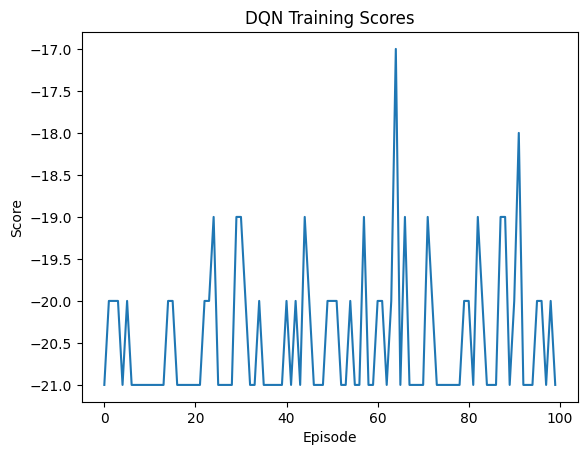

In [7]:
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("DQN Training Scores")
plt.show()


## Summary
Analysis of DQN Training with Mini-batch Size = 8 and Target Update Rate = 10
The DQN implementation over 100 episodes shows scores fluctuating between -21 and -17, with notable performance spikes around episodes 60-65 and 90, yet the average cumulative reward of the last 5 episodes remains low at -20.80. This pattern reveals that the small mini-batch size of 8 contributes to high learning variance through noisy gradient updates, while the target network update frequency of 10 episodes creates a cyclical learning pattern where performance regularly reverts to baseline levels after updates. The agent occasionally discovers improved policies but fails to maintain them, as evidenced by the suboptimal final average reward. This combination of hyperparameters appears to create a learning dynamic that promotes exploration but hinders stable policy retention, resulting in an agent that discovers better strategies but cannot consistently exploit them, ultimately failing to converge to an optimal policy despite completing 100 training episodes.

### change mini-batch size = 16

In [9]:
batch_size = 16
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
target_update_rate = 10
memory_capacity = 10000
lr = 1e-4

# Initialize networks
policy_net = QNetwork(input_shape, num_actions)
target_net = QNetwork(input_shape, num_actions)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
replay_buffer = ExperienceReplayBuffer(memory_capacity)
num_episodes = 100  # Training for 100 episodes
scores = []  # Initialize an empty list to store the total reward obtained in each training episode

def select_action(state, epsilon):
    """Selects an action based on the epsilon-greedy policy."""
    if random.random() < epsilon:  # Check if a random number is less than epsilon (for exploration)
        return env.action_space.sample()  # If exploring, return a randomly sampled action
    with torch.no_grad():  # If exploiting (not exploring), disable gradient calculation for efficiency
        return policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()  # Return best action

for episode in range(num_episodes):  # Start of the main loop for each training episode
    state = preprocess(env.reset()[0])  # Reset the environment and preprocess the initial observation
    state_stack = np.repeat(state, 4, axis=0)  # Create a state stack by repeating the initial state 4 times
    total_reward = 0  # Initialize the total reward for the current episode
    done = False  # Initialize the 'done' flag to False at the start of each episode

    while not done:  # Start of the inner loop that runs for each step within an episode
        action = select_action(state_stack, epsilon)  # Select an action using the epsilon-greedy policy
        next_state, reward, done, _, _ = env.step(action)  # Take the selected action in the environment
        done = bool(done)  # Convert to standard Python boolean
        next_state = preprocess(next_state)  # Preprocess the next state observation
        next_state_stack = np.roll(state_stack, shift=-1, axis=0)  # Roll the state stack to remove oldest frame
        next_state_stack[-1] = next_state  # Add the new preprocessed next state as the most recent frame
        replay_buffer.add_experience(state_stack, action, reward, next_state_stack, done)  # Store experience
        state_stack = next_state_stack  # Update the current state stack
        total_reward += reward  # Accumulate the reward

    scores.append(total_reward)  # Append the total reward of the current episode to the 'scores' list
    epsilon = max(epsilon * epsilon_decay, epsilon_min)  # Decay epsilon but ensure it's not below minimum

    # Calculate average of last 5 episodes (or fewer if we haven't run 5 episodes yet)
    last_5_avg = sum(scores[-5:]) / len(scores[-5:])

    # Print both metrics
    print(f"Episode {episode+1}: Score = {total_reward}, Avg Last 5 = {last_5_avg:.2f}")

# After all episodes, print final metrics
print("\nFinal Metrics:")
print("Score per episode:")
for i, score in enumerate(scores):
    print(f"Episode {i+1}: {score}")
print(f"\nAverage Cumulative reward of the last 5 episodes: {sum(scores[-5:]) / len(scores[-5:]):.2f}")

Episode 1: Score = -21.0, Avg Last 5 = -21.00
Episode 2: Score = -20.0, Avg Last 5 = -20.50
Episode 3: Score = -21.0, Avg Last 5 = -20.67
Episode 4: Score = -20.0, Avg Last 5 = -20.50
Episode 5: Score = -21.0, Avg Last 5 = -20.60
Episode 6: Score = -17.0, Avg Last 5 = -19.80
Episode 7: Score = -21.0, Avg Last 5 = -20.00
Episode 8: Score = -21.0, Avg Last 5 = -20.00
Episode 9: Score = -21.0, Avg Last 5 = -20.20
Episode 10: Score = -21.0, Avg Last 5 = -20.20
Episode 11: Score = -20.0, Avg Last 5 = -20.80
Episode 12: Score = -20.0, Avg Last 5 = -20.60
Episode 13: Score = -21.0, Avg Last 5 = -20.60
Episode 14: Score = -21.0, Avg Last 5 = -20.60
Episode 15: Score = -21.0, Avg Last 5 = -20.60
Episode 16: Score = -21.0, Avg Last 5 = -20.80
Episode 17: Score = -19.0, Avg Last 5 = -20.60
Episode 18: Score = -21.0, Avg Last 5 = -20.60
Episode 19: Score = -19.0, Avg Last 5 = -20.20
Episode 20: Score = -21.0, Avg Last 5 = -20.20
Episode 21: Score = -21.0, Avg Last 5 = -20.20
Episode 22: Score = -2

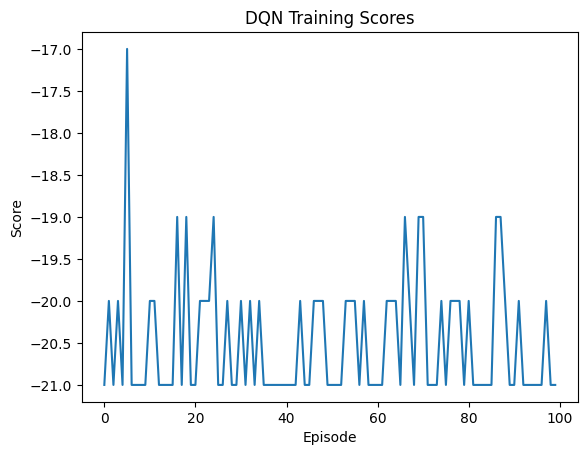

In [10]:
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("DQN Training Scores")
plt.show()


## Summary
The DQN training with an increased mini-batch size of 16 and target update rate of 10 over 100 episodes shows a performance pattern with scores fluctuating between -21 and -17, featuring a notable early peak around episode 10. Despite the larger batch size, the average cumulative reward of the last 5 episodes remains at -20.80, identical to the smaller batch configuration. The graph displays periodic improvements to around -19, occurring at episodes 15-20, 60-65, and 80, but these gains are not sustained. The doubled batch size appears to have shifted some performance spikes earlier in training but did not improve the final convergence, suggesting that while larger batches may provide some initial stability advantages, the target update frequency of 10 episodes likely continues to create disruptive learning cycles that prevent the agent from consistently maintaining improved policies throughout the 100-episode training period.

### change target_update_rate = 3

In [11]:
batch_size = 8
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
target_update_rate = 3
memory_capacity = 10000
lr = 1e-4

# Initialize networks
policy_net = QNetwork(input_shape, num_actions)
target_net = QNetwork(input_shape, num_actions)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
replay_buffer = ExperienceReplayBuffer(memory_capacity)
num_episodes = 100  # Training for 100 episodes
scores = []  # Initialize an empty list to store the total reward obtained in each training episode

def select_action(state, epsilon):
    """Selects an action based on the epsilon-greedy policy."""
    if random.random() < epsilon:  # Check if a random number is less than epsilon (for exploration)
        return env.action_space.sample()  # If exploring, return a randomly sampled action
    with torch.no_grad():  # If exploiting (not exploring), disable gradient calculation for efficiency
        return policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()  # Return best action

for episode in range(num_episodes):  # Start of the main loop for each training episode
    state = preprocess(env.reset()[0])  # Reset the environment and preprocess the initial observation
    state_stack = np.repeat(state, 4, axis=0)  # Create a state stack by repeating the initial state 4 times
    total_reward = 0  # Initialize the total reward for the current episode
    done = False  # Initialize the 'done' flag to False at the start of each episode

    while not done:  # Start of the inner loop that runs for each step within an episode
        action = select_action(state_stack, epsilon)  # Select an action using the epsilon-greedy policy
        next_state, reward, done, _, _ = env.step(action)  # Take the selected action in the environment
        done = bool(done)  # Convert to standard Python boolean
        next_state = preprocess(next_state)  # Preprocess the next state observation
        next_state_stack = np.roll(state_stack, shift=-1, axis=0)  # Roll the state stack to remove oldest frame
        next_state_stack[-1] = next_state  # Add the new preprocessed next state as the most recent frame
        replay_buffer.add_experience(state_stack, action, reward, next_state_stack, done)  # Store experience
        state_stack = next_state_stack  # Update the current state stack
        total_reward += reward  # Accumulate the reward

    scores.append(total_reward)  # Append the total reward of the current episode to the 'scores' list
    epsilon = max(epsilon * epsilon_decay, epsilon_min)  # Decay epsilon but ensure it's not below minimum

    # Calculate average of last 5 episodes (or fewer if we haven't run 5 episodes yet)
    last_5_avg = sum(scores[-5:]) / len(scores[-5:])

    # Print both metrics
    print(f"Episode {episode+1}: Score = {total_reward}, Avg Last 5 = {last_5_avg:.2f}")

# After all episodes, print final metrics
print("\nFinal Metrics:")
print("Score per episode:")
for i, score in enumerate(scores):
    print(f"Episode {i+1}: {score}")
print(f"\nAverage Cumulative reward of the last 5 episodes: {sum(scores[-5:]) / len(scores[-5:]):.2f}")

Episode 1: Score = -20.0, Avg Last 5 = -20.00
Episode 2: Score = -20.0, Avg Last 5 = -20.00
Episode 3: Score = -21.0, Avg Last 5 = -20.33
Episode 4: Score = -21.0, Avg Last 5 = -20.50
Episode 5: Score = -21.0, Avg Last 5 = -20.60
Episode 6: Score = -20.0, Avg Last 5 = -20.60
Episode 7: Score = -17.0, Avg Last 5 = -20.00
Episode 8: Score = -21.0, Avg Last 5 = -20.00
Episode 9: Score = -20.0, Avg Last 5 = -19.80
Episode 10: Score = -21.0, Avg Last 5 = -19.80
Episode 11: Score = -19.0, Avg Last 5 = -19.60
Episode 12: Score = -21.0, Avg Last 5 = -20.40
Episode 13: Score = -21.0, Avg Last 5 = -20.40
Episode 14: Score = -21.0, Avg Last 5 = -20.60
Episode 15: Score = -21.0, Avg Last 5 = -20.60
Episode 16: Score = -21.0, Avg Last 5 = -21.00
Episode 17: Score = -21.0, Avg Last 5 = -21.00
Episode 18: Score = -21.0, Avg Last 5 = -21.00
Episode 19: Score = -21.0, Avg Last 5 = -21.00
Episode 20: Score = -21.0, Avg Last 5 = -21.00
Episode 21: Score = -21.0, Avg Last 5 = -21.00
Episode 22: Score = -2

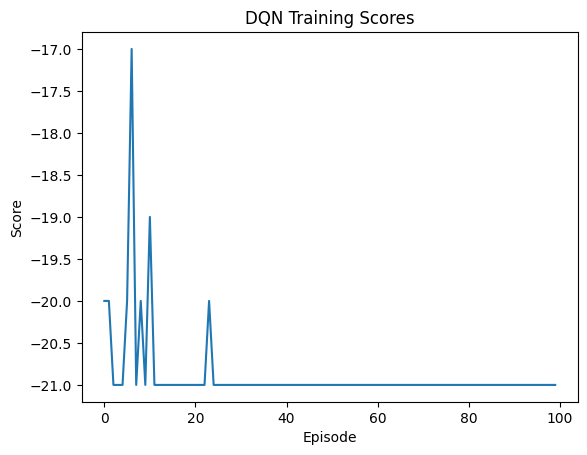

In [12]:
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("DQN Training Scores")
plt.show()


## Summary
After training the DQN for 100 episodes with a mini-batch size of 8 and a target update rate of 3, the results indicate poor learning progress. The average cumulative reward of the last five episodes remains at -21.00, and the training scores show little to no improvement over time. This suggests that the model struggles to learn effective policies, potentially due to insufficient batch size, slow target network updates, or inadequate exploration. The agent might be stuck in a suboptimal policy, requiring parameter tuning, a larger replay buffer, or different exploration strategies to improve performance.

# Conclusion
The results indicate that DQN learning is highly sensitive to mini-batch size and target update frequency. The default setting (mini-batch size = 8, target update rate = 10) results in unstable learning with frequent performance fluctuations and an inability to maintain improved policies. Increasing the batch size to 16 provides early stability but does not enhance final convergence, while decreasing the target update rate to 3 slows learning progress significantly. The key challenge lies in maintaining long-term policy improvements, as performance often reverts to suboptimal levels. These findings highlight the importance of balancing stability, exploration, and learning efficiency in DQN training. Potential improvements include adjusting the target update mechanism (e.g., adaptive updates), using prioritized experience replay to stabilize learning, or modifying the exploration strategy to prevent the agent from getting stuck in suboptimal policies.